In [340]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
import cellpose
from cellpose import models, io, core, dynamics
import time
from sklearn.model_selection import train_test_split
from statistics import mean
from u_net import UNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from ptflops import get_model_complexity_info

In [341]:
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        mean = np.mean(files)
        std = np.std(files)
        standardized_files = [(image-mean)/std for image in files]
        return standardized_files
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

def split_image(img):
    
    # Split the input array into smaller arrays of size 256x256
    sub_images = []
    for i in range(0, img.shape[0], 256):
        for j in range(0, img.shape[1], 256):
            sub_img = img[i:i+256, j:j+256]
            sub_images.append(sub_img)
            
    return sub_images

def combine_images(sub_images):
    
    # Create a NumPy array of size 1024x1024 to store the combined image
    img = np.zeros((1024, 1024))
    
    # Combine the smaller arrays into the larger image
    k = 0
    for i in range(0, img.shape[0], 256):
        for j in range(0, img.shape[1], 256):
            img[i:i+256, j:j+256] = sub_images[k]
            k += 1
            
    return img

def get_IoU(predicted_masks,gt_masks, return_list=False):
    intersection_unions = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        union = np.logical_or(predicted_masks[i], gt_masks[i]).sum()
        intersection_unions.append(intersection/union)
    if return_list:
        return intersection_unions
    return mean(intersection_unions)

def get_dice(predicted_masks,gt_masks, return_list=False):
    dices = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())
        dices.append(dice)
    if return_list:
        return dices
    return mean(dices)

def get_accuracy(predicted_masks,gt_masks,return_list=False):
    accuracies = []
    for i in range(len(predicted_masks)):
        accuracies.append(np.mean(predicted_masks[i] == gt_masks[i]))
    if return_list:
        return accuracies
    return mean(accuracies)

In [342]:
images, masks = get_data("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DH-GOWT1/', set = '0102',normalise_images=True)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [343]:
cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model='c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\cellpose_trained_model_GOWT1_3')
cellprobs_train = []
cellmasks_train = []
for i in range(len(X_train)):
    print(i)
    image = X_train[i]
    masks, flows, styles = cellpose_model.eval(image, batch_size=1, channels=[0,0], diameter=cellpose_model.diam_labels)
    cellprobs_train.append(flows[2])
    cellmasks_train.append(masks)

cellprobs_test = []
cellmasks_test = []
for i in range(len(X_test)):
    print(i)
    image = X_test[i]
    masks, flows, styles = cellpose_model.eval(image, batch_size=1, channels=[0,0], diameter=cellpose_model.diam_labels)
    cellprobs_test.append(flows[2])
    cellmasks_test.append(masks)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [344]:
cellprobs_train_norm = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in cellprobs_train]
cellmasks_train_binary = [np.where(image > 0, 1, 0) for image in cellmasks_train]
cellprobs_test_norm = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in cellprobs_test]
cellmasks_test_binary = [np.where(image > 0, 1, 0) for image in cellmasks_test]

In [345]:
#cell images
X_train_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in X_train]
X_test_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in X_test]

#cell probability maps
y_cp_train_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cellprobs_train_norm]
y_cp_test_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cellprobs_test_norm]

#cell masks (from Cellpose)
y_cm_train_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cellmasks_train_binary]
y_cm_test_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cellmasks_test_binary]

#for testing purposes
y_test_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in y_test]
y_test_padded_binarised = [np.where(img>0,1,0) for img in y_test_padded]

In [346]:
def split_image_set(set):
    splitted = []
    for image in set:
        for i in range(0, 1024, 256):
            for j in range(0, 1024, 256):
                sub_img = image[i:i+256, j:j+256]
                splitted.append(sub_img)
    return splitted

X_train_padded_splitted = split_image_set(X_train_padded)
X_test_padded_splitted = split_image_set(X_test_padded)
y_cp_train_padded_splitted = split_image_set(y_cp_train_padded)
y_cp_test_padded_splitted = split_image_set(y_cp_test_padded)
y_cm_train_padded_splitted = split_image_set(y_cm_train_padded)
y_cm_test_padded_splitted = split_image_set(y_cm_test_padded)

In [347]:
print(len(X_train_padded_splitted))

2352


In [348]:
X_train_padded_splitted = np.array(X_train_padded_splitted)
X_test_padded_splitted = np.array(X_test_padded_splitted)
y_cp_train_padded_splitted = np.array(y_cp_train_padded_splitted)
y_cp_test_padded_splitted = np.array(y_cp_test_padded_splitted)
y_cm_train_padded_splitted = np.array(y_cm_train_padded_splitted)
y_cm_test_padded_splitted = np.array(y_cm_test_padded_splitted)

X_train_padded_splitted = X_train_padded_splitted[y_cm_train_padded_splitted.sum(axis=(1,2))!=0]
y_cp_train_padded_splitted = y_cp_train_padded_splitted[y_cm_train_padded_splitted.sum(axis=(1,2))!=0]
y_cm_train_padded_splitted = y_cm_train_padded_splitted[y_cm_train_padded_splitted.sum(axis=(1,2))!=0]

In [349]:
#augment with rotations
X_train_padded_splitted_rot = []
y_cp_train_padded_splitted_rot = []
y_cm_train_padded_splitted_rot = []
for i in range(len(X_train_padded_splitted)):
    for j in range(1,4):
        X_train_padded_splitted_rot.append(np.rot90(X_train_padded_splitted[i],j))
        y_cp_train_padded_splitted_rot.append(np.rot90(y_cp_train_padded_splitted[i],j))
        y_cm_train_padded_splitted_rot.append(np.rot90(y_cm_train_padded_splitted[i],j))

In [350]:
print(len(X_train_padded_splitted_rot))

5622


In [351]:
class ImageDataset(Dataset):
    def __init__(self, image, cellprob, cellmask):
        self.image = image
        self.cellprob = cellprob
        self.cellmask = cellmask

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        cellprob = self.cellprob[idx]
        cellmask = self.cellmask[idx]
        return img, cellprob, cellmask
    
X_train_torch = [torch.from_numpy(np.array(X_train_padded_splitted_rot[i])) for i in range(len(X_train_padded_splitted_rot))]
X_test_torch = [torch.from_numpy(np.array(X_test_padded_splitted[i])) for i in range(len(X_test_padded_splitted))]

y_cp_train_torch = [torch.from_numpy(np.array(y_cp_train_padded_splitted_rot[i])).type(torch.float32) for i in range(len(y_cp_train_padded_splitted_rot))]
y_cp_test_torch = [torch.from_numpy(np.array(y_cp_test_padded_splitted[i])).type(torch.float32) for i in range(len(y_cp_test_padded_splitted))]

y_cm_train_torch = [torch.from_numpy(np.array(y_cm_train_padded_splitted_rot[i])).type(torch.float32) for i in range(len(y_cm_train_padded_splitted_rot))]
y_cm_test_torch = [torch.from_numpy(np.array(y_cm_test_padded_splitted[i])).type(torch.float32) for i in range(len(y_cm_test_padded_splitted))]

train_dataset = ImageDataset(X_train_torch, y_cp_train_torch, y_cm_train_torch)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = ImageDataset(X_test_torch, y_cp_test_torch, y_cm_test_torch)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [352]:
class KDLoss(torch.nn.Module):
    def __init__(self, alpha=0.5, beta = 0.5, temperature=2):
        super(KDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    def forward(self, y_pred_logits, y_cp_true, y_cm_true):

        kd_loss = F.binary_cross_entropy_with_logits(y_pred_logits, y_cm_true)

        ce_loss = F.binary_cross_entropy_with_logits(y_pred_logits, y_cp_true)  # compute binary cross-entropy loss

        #y_pred_mask = torch.sigmoid(y_pred_logits)  # compute predicted probabilities
        #y_pred_mask = torch.where(y_pred_mask>0.4,1.0,0.0) # binarise
          # compute KL divergence loss
        
        loss = self.alpha * kd_loss + self.beta * ce_loss  # combine losses
        return loss
    
def kl_div_loss(outputs_student, outputs_teacher, temperature):
    # Apply softmax to both outputs
    #outputs_student = F.softmax(outputs_student / temperature, dim=1)
    #outputs_teacher = F.softmax(outputs_teacher / temperature, dim=1)
    
    # Calculate the KL divergence loss
    loss = F.kl_div(outputs_student, outputs_teacher, reduction='batchmean') * temperature**2
    
    return loss

In [353]:
model = UNet()
model = model.to('cuda:0')

In [360]:
loss_fn = KDLoss()
#loss_fn = kl_div_loss
#loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.KLDivLoss(reduction='batchmean')
optimiser = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.001, max_lr=0.1)

In [364]:
for epoch in range(50):
    start_time = time.time()
    model.train()

    train_loss = 0
    for image, cellprob, cellmask in train_loader:
        (image,cellprob,cellmask) = (image.to('cuda:0'), cellprob.to('cuda:0'),cellmask.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        pred = model(image)# make a prediction
        
        cellprob = torch.unsqueeze(cellprob,1)
        cellmask = torch.unsqueeze(cellmask,1)

        #loss = loss_fn(pred, cellprob,10) # calculate the loss of that prediction
        loss = loss_fn(pred, cellprob, cellmask) # calculate the loss of that prediction
        train_loss += loss
    
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        scheduler.step()
    train_loss = train_loss.item()/len(train_loader)
    
    test_loss = 0
    with torch.no_grad():
        for image, cellprob, cellmask in test_loader:
            (image,cellprob,cellmask) = (image.to('cuda:0'), cellprob.to('cuda:0'),cellmask.to('cuda:0')) # sending the data to the device (cpu or GPU)

            image = image.unsqueeze(1)
            pred = model(image)# make a prediction
            
            cellprob = torch.unsqueeze(cellprob,1)
            cellmask = torch.unsqueeze(cellmask,1)

            #loss = loss_fn(pred, cellprob,10) # calculate the loss of that prediction
            
            loss = loss_fn(pred, cellprob, cellmask) # calculate the loss of that prediction
            test_loss += loss

        predictions = []
        for image in X_test_padded:
            tiles = split_image(image)
            tiles = np.array(tiles)
            tiles = tiles.astype(np.float32)
            tiles = torch.from_numpy(tiles)
            tiles = torch.unsqueeze(tiles,1)
            tiles = tiles.to('cuda:0')
            outputs = model(tiles)
            outputs = outputs.cpu().detach().numpy()
            outputs = np.squeeze(outputs)
            outputs = 1/(1+np.exp(-outputs))
            outputs = np.where(outputs>0.4,1,0)
            output = combine_images(outputs)
            predictions.append(output)

        IoU = get_IoU(predictions, y_test_padded_binarised)
        dice = get_dice(predictions, y_test_padded_binarised)

    test_loss = test_loss.item()/len(test_loader)

    print('epoch: ', epoch, 'train loss', train_loss, 'test loss', test_loss, 'IoU:', IoU, 'dice:', dice, 'time: ', time.time()-start_time)

epoch:  0 train loss 0.43300124015102687 test loss 0.43529118718327703 IoU: 0.7638879417668589 dice: 0.8659894010466962 time:  23.850470542907715
epoch:  1 train loss 0.4330601916035073 test loss 0.4355583190917969 IoU: 0.7657092650878361 dice: 0.8671781065231126 time:  24.15986704826355
epoch:  2 train loss 0.43326591394025604 test loss 0.4353925859605944 IoU: 0.7643563081302557 dice: 0.8663260163404378 time:  24.516403675079346
epoch:  3 train loss 0.4329642544091172 test loss 0.4355055319296347 IoU: 0.7645748292398842 dice: 0.8664352108608391 time:  24.730539798736572
epoch:  4 train loss 0.43305185678842906 test loss 0.4353141784667969 IoU: 0.7656940185432479 dice: 0.8671700406918026 time:  24.808050394058228
epoch:  5 train loss 0.43319441685466303 test loss 0.43524216316841746 IoU: 0.763998849584665 dice: 0.86607803372474 time:  24.882097721099854
epoch:  6 train loss 0.4329111633734886 test loss 0.4352241722313133 IoU: 0.7610446502758267 dice: 0.8641311932235959 time:  24.910154

In [365]:
#save model
torch.save(model.state_dict(), 'c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\distillation_model_GOWT1_5')

In [366]:
predictions = []
for image in X_test_padded:
    tiles = split_image(image)
    tiles = np.array(tiles)
    tiles = tiles.astype(np.float32)
    tiles = torch.from_numpy(tiles)
    tiles = torch.unsqueeze(tiles,1)
    tiles = tiles.to('cuda:0')
    outputs = model(tiles)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.squeeze(outputs)
    outputs = 1/(1+np.exp(-outputs))
    outputs = np.where(outputs>0.4,1,0)
    output = combine_images(outputs)
    predictions.append(output)



IoU = get_IoU(predictions, y_test_padded_binarised, return_list=True)
accuracy = get_accuracy(predictions, y_test_padded_binarised, return_list=True)

print(mean(IoU))
print(max(IoU))
print(min(IoU))
print(mean(accuracy))
print(max(accuracy))
print(min(accuracy))

0.768589668171111
0.8077295934854263
0.7409283672020417
0.9886411976169895
0.9914884567260742
0.9853391647338867


In [146]:
y_test_padded = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in y_test]
print(y_test_padded[0].shape)

(1024, 1024)


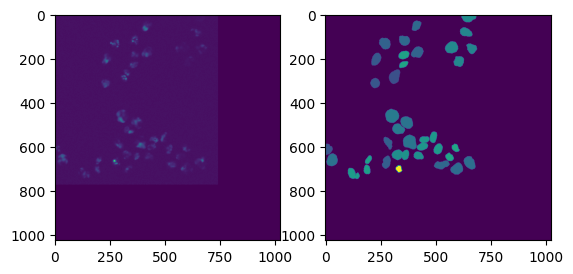

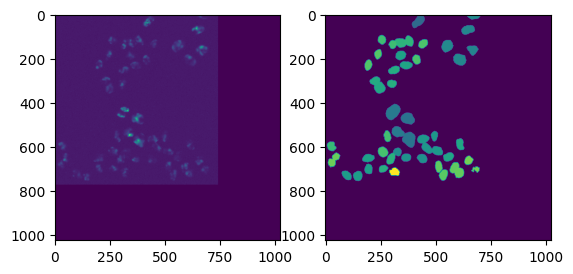

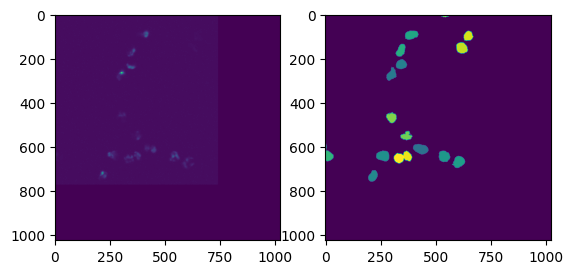

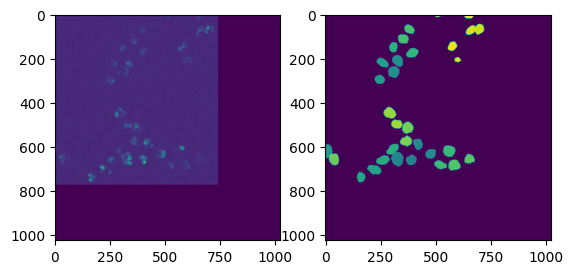

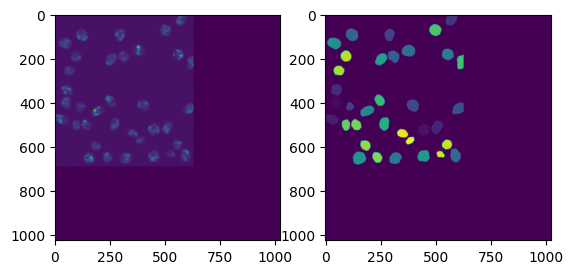

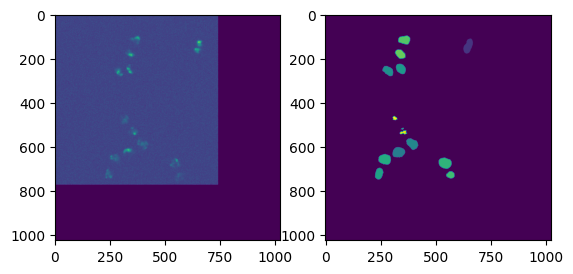

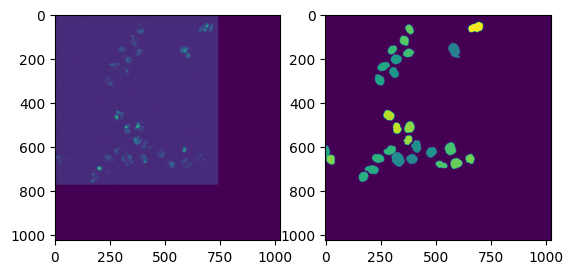

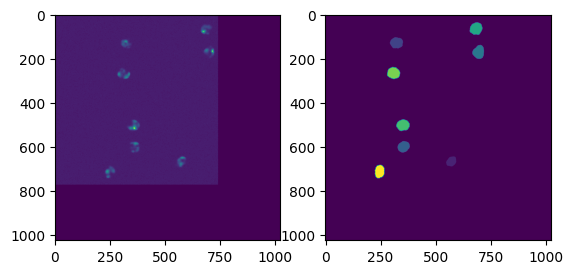

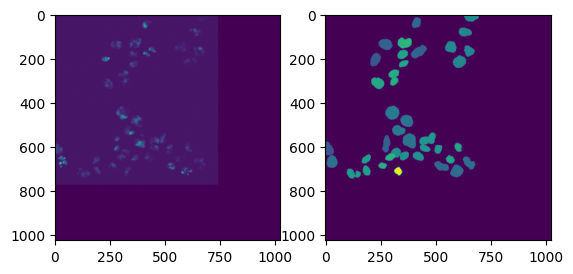

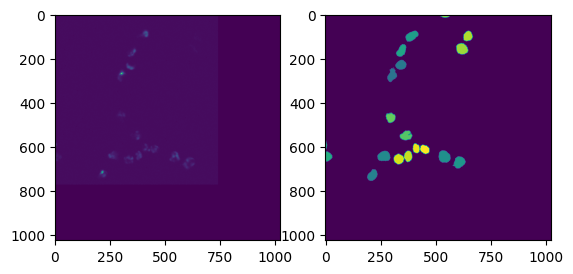

In [151]:
for i in range(10):
    plt.subplot(1,2,1)
    plt.imshow(X_test_padded[i])
    plt.subplot(1,2,2)
    plt.imshow(y_test_padded[i])
    plt.show()